In [59]:
options(repos = c(CRAN = "https://cloud.r-project.org"))

if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2, dplyr, lubridate, stringr, readxl, data.table, gdata, scales, data.table)

source("..//functions-1.R")

In [60]:
data.2014 <- read.csv('../data/output/data-2014.csv')
data.2015 <- read.csv('../data/output/data-2015.csv')
data.2016 <- read.csv('../data/output/data-2016.csv')
data.2017 <- read.csv('../data/output/data-2017.csv')
data.2018 <- read.csv('../data/output/data-2018.csv')
data.2019 <- read.csv('../data/output/data-2019.csv')

In [61]:
data.full <- rbind(data.2014, data.2015, data.2016, data.2017, data.2018, data.2019)

glimpse(data.full)

Rows: 449,046
Columns: 58
$ contractid          <chr> "H0022", "H0022", "H0022", "H0022", "H0022", "H002…
$ planid              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4,…
$ fips                <int> 39023, 39035, 39051, 39055, 39057, 39085, 39093, 3…
$ year                <int> 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 20…
$ n_nonmiss           <int> 6, 8, 7, 0, 6, 8, 8, 7, 8, 6, 4, 7, 12, 12, 12, 12…
$ avg_enrollment      <dbl> 72.00000, 330.12500, 24.57143, NA, 120.83333, 41.5…
$ sd_enrollment       <dbl> 7.2111026, 10.6158574, 1.8126539, NA, 15.7659972, …
$ min_enrollment      <int> 60, 309, 23, NA, 90, 39, 29, 299, 24, 431, 11, 71,…
$ max_enrollment      <int> 81, 344, 28, NA, 135, 44, 43, 440, 26, 713, 12, 85…
$ first_enrollment    <int> 60, 309, 24, NA, 90, 41, 29, 299, 24, 431, 11, 71,…
$ last_enrollment     <int> 81, 344, 24, NA, 135, 44, 43, 440, 24, 713, 12, 82…
$ state               <chr> "OH", "OH", "OH", "OH", "OH", "OH", "OH", "OH", "O…
$ county      

Problem 1


In [100]:
plan_counts <- data.full %>% distinct(fips, year, contractid)

In [101]:
plan_counts <- plan_counts %>% 
    group_by(fips, year) %>%
    summarise(plan_count = n(), .groups = "drop")

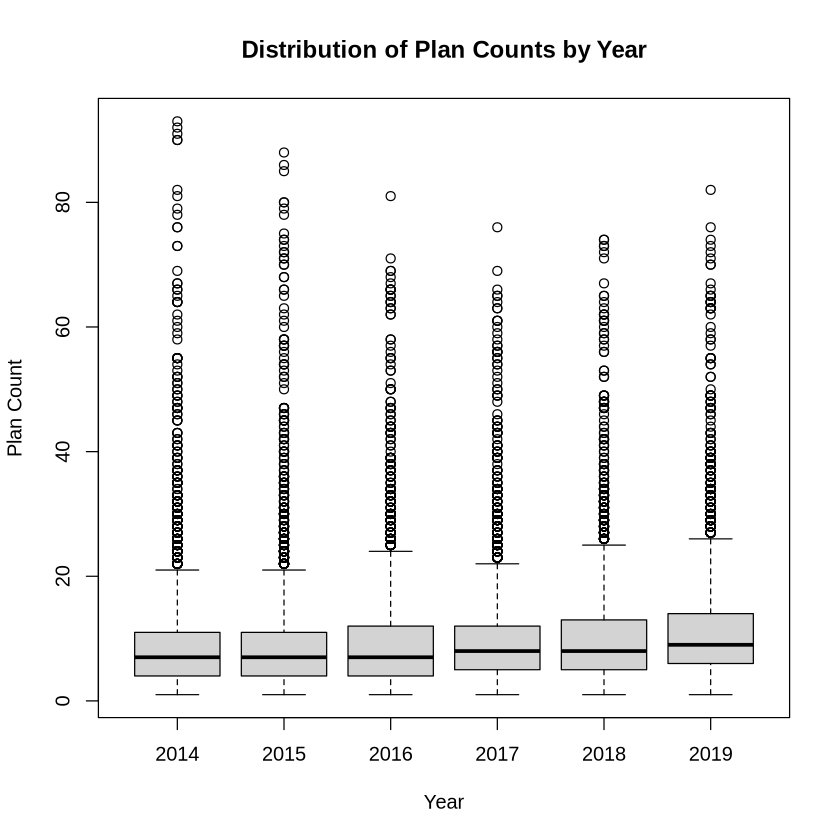

In [102]:
boxplot(plan_count ~ year, data = plan_counts,
        xlab = "Year",
        ylab = "Plan Count",
        main = "Distribution of Plan Counts by Year")

In [103]:
data.full <- data.full %>% mutate (basic_premium = case_when(
        rebate_partc > 0 ~ 0,
        partd == "No" & !is.na(premium) & is.na(premium_partc) ~ premium,
        TRUE ~ premium_partc
      ),
      bid = case_when(
        rebate_partc == 0 & basic_premium > 0 ~ (payment_partc + basic_premium) / riskscore_partc,
        rebate_partc > 0  | basic_premium == 0 ~  payment_partc / riskscore_partc,
        TRUE ~ NA_real_
      )
    )

Problem 2


Warning message:
“Removed 8956 rows containing non-finite values (`stat_bin()`).”


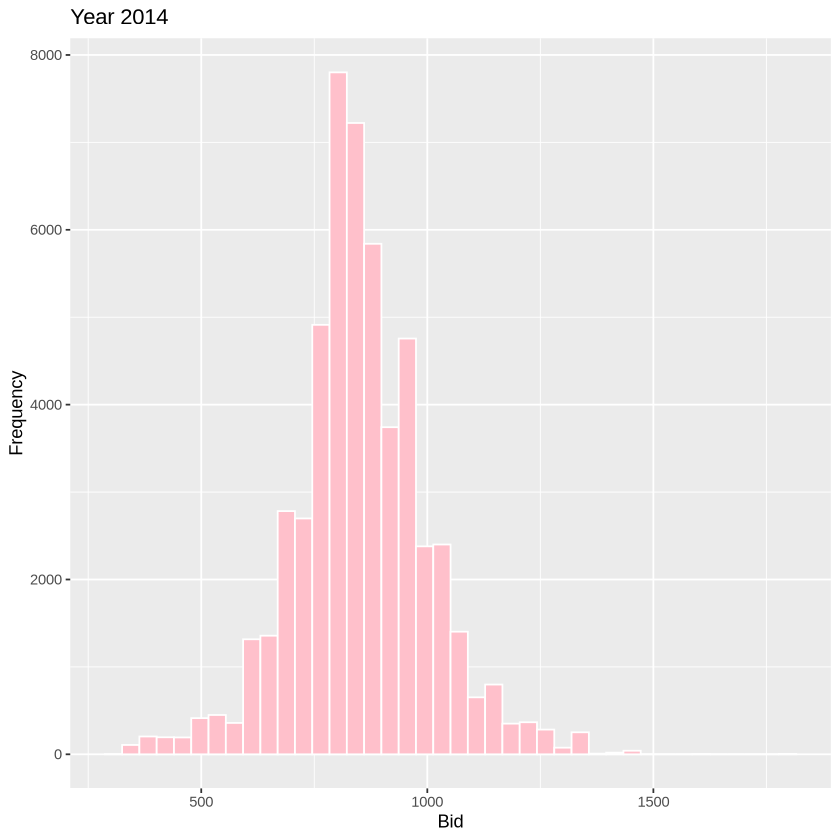

In [104]:
data.full %>%
  filter(year == 2014) %>%
  ggplot(aes(x = bid)) +
  geom_histogram(bins = 40, fill = "pink", color = "white")+
  labs(
    x = "Bid",
    y = "Frequency",
    title = "Year 2014"
  )

Warning message:
“Removed 8094 rows containing non-finite values (`stat_bin()`).”


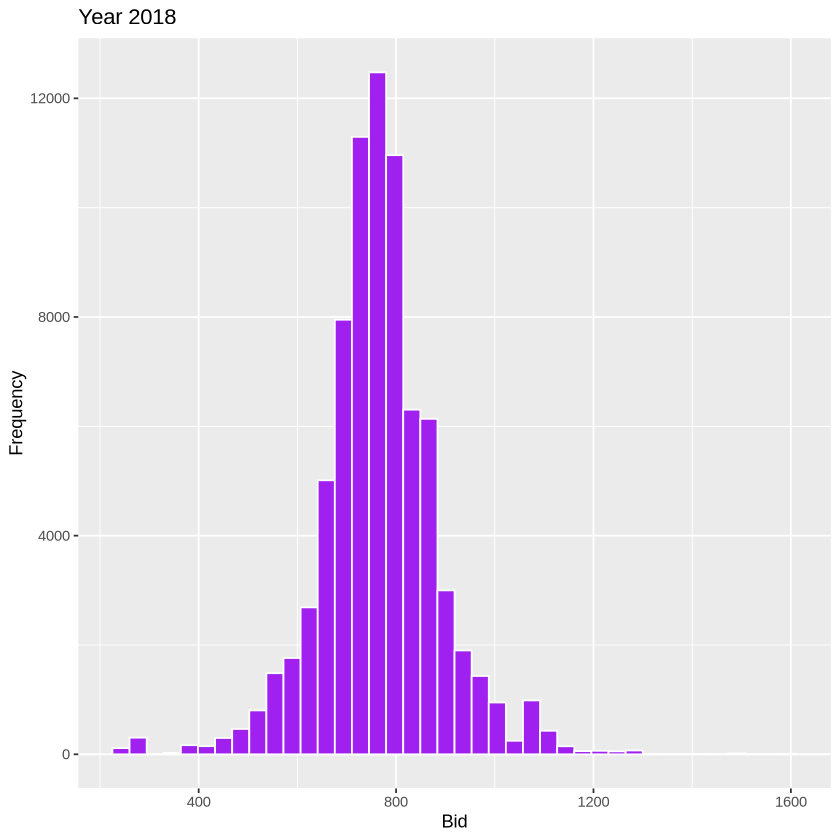

In [105]:
data.full %>%
  filter(year == 2018) %>%
  ggplot(aes(x = bid)) +
  geom_histogram(bins = 40, fill = "purple", color = "white")+
  labs(
    x = "Bid",
    y = "Frequency",
    title = "Year 2018"
  )

Problem 3


In [106]:
hhi_data <- data.full %>%
  mutate(share = avg_enrollment / avg_enrolled) %>%
  group_by(fips, year) %>%
  summarise(HHI = sum(share^2, na.rm = TRUE), .groups = "drop") %>% 
  group_by(year) %>% 
  summarise(mean_HHI = mean(HHI, na.rm = TRUE), .groups = "drop")

In [107]:
hhi_data

year,mean_HHI
<int>,<dbl>
2014,0.1722958
2015,0.1672992
2016,0.1673735
2017,0.1570308
2018,0.1373105
2019,0.1177533


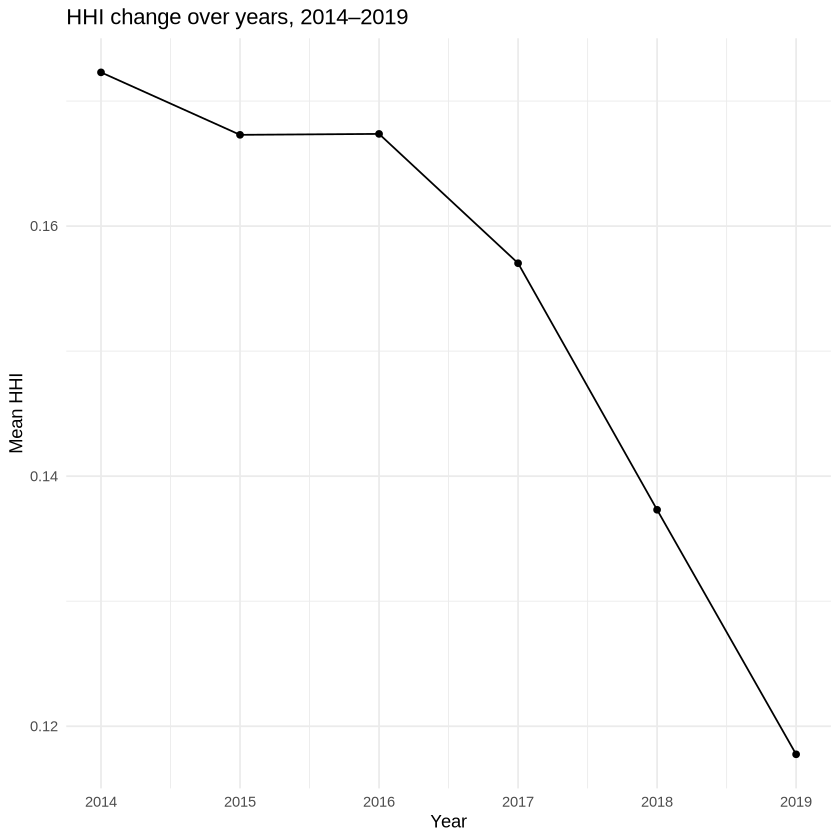

In [108]:
ggplot(hhi_data, aes(x = year, y = mean_HHI)) + geom_line() + geom_point() + theme_minimal() + labs(
    x = "Year",
    y = "Mean HHI",
    title = "HHI change over years, 2014–2019"
  )

Problem 4


In [109]:
ma_share_yearly <- data.full %>%
  mutate(ma_share = avg_enrolled / avg_eligibles) %>%
  group_by(year) %>%
  summarise(mean_share = mean(ma_share, na.rm = TRUE), .groups = "drop")

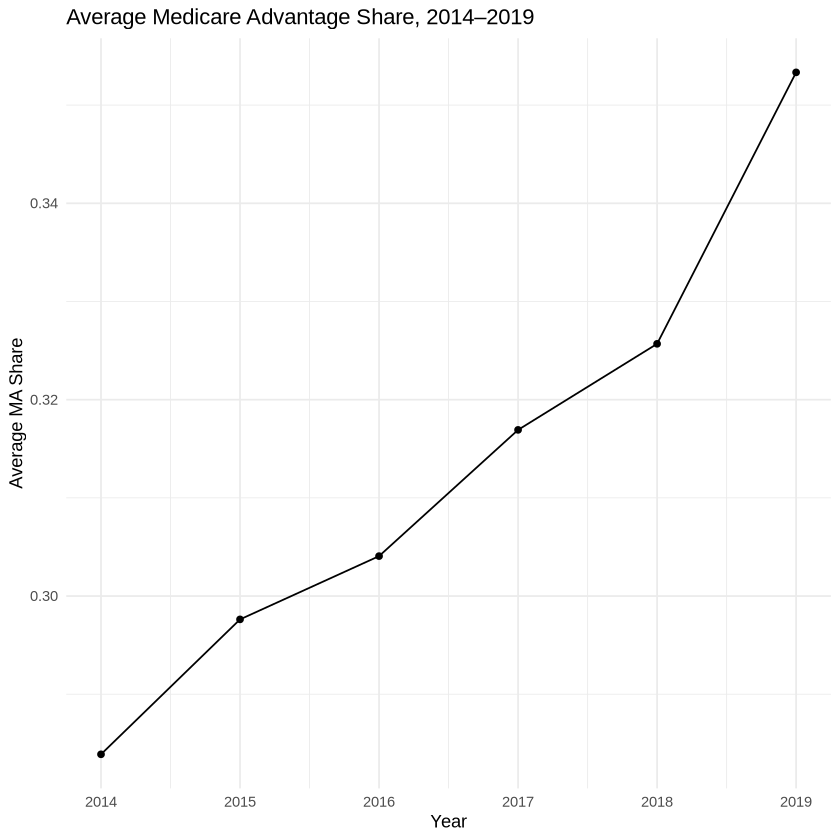

In [110]:
ggplot(ma_share_yearly, aes(x = year, y = mean_share)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(
    x = "Year",
    y = "Average MA Share",
    title = "Average Medicare Advantage Share, 2014–2019"
  )

Estimate ATEs

Problem 5


In [72]:
data.full.2018 <- data.full %>% filter(year == 2018)

In [73]:
colnames(data.full.2018)

[1] "contractid"          "planid"              "fips"               
 [4] "year"                "n_nonmiss"           "avg_enrollment"     
 [7] "sd_enrollment"       "min_enrollment"      "max_enrollment"     
[10] "first_enrollment"    "last_enrollment"     "state"              
[13] "county"              "org_type"            "plan_type"          
[16] "partd"               "snp"                 "eghp"               
[19] "org_name"            "org_marketing_name"  "plan_name"          
[22] "parent_org"          "contract_date"       "state_long"         
[25] "county_long"         "n_elig"              "n_enrol"            
[28] "avg_eligibles"       "sd_eligibles"        "min_eligibles"      
[31] "max_eligibles"       "first_eligibles"     "last_eligibles"     
[34] "avg_enrolled"        "sd_enrolled"         "min_enrolled"       
[37] "max_enrolled"        "first_enrolled"      "last_enrolled"      
[40] "ssa"                 "ncount"              "state_name"         
[43] "premium"             "premium_partc"       "premium_partd_basic"
[46] "premium_partd_supp"  "premium_partd_total" "partd_deductible"   
[49] "riskscore_partc"     "payment_partc"       "rebate_partc"       
[52] "payment_partd"       "directsubsidy_partd" "reinsurance_partd"  
[55] "costsharing_partd"   "riskscore_partd"     "basic_premium"      
[58] "bid"

In [74]:
hhi_data_2018 <- data.full.2018 %>%
  mutate(share = avg_enrollment / avg_enrolled) %>%
  group_by(fips, year) %>%
  mutate(HHI = sum(share^2, na.rm = TRUE)) %>%
  ungroup()

In [75]:
hhi_data_33 <- quantile(hhi_data_2018$HHI, 0.33, na.rm = TRUE)
hhi_data_66 <- quantile(hhi_data_2018$HHI, 0.66, na.rm = TRUE)

In [76]:
hhi_high <- hhi_data_2018 %>% filter(hhi_data_2018$HHI >= hhi_data_66)
hhi_low <- hhi_data_2018 %>% filter(hhi_data_2018$HHI <= hhi_data_33)

In [77]:
avg_high <- hhi_high %>% summarise(avg_66 = mean(bid, na.rm = TRUE))
avg_low <- hhi_low %>% summarise(avg_33 = mean(bid, na.rm = TRUE))

cat("Average Bid in Uncompetitive Markets:", avg_high$avg_66, "\n")
cat("Average Bid in Competitive Markets:", avg_low$avg_33, "\n")

Average Bid in Uncompetitive Markets: 770.536 
Average Bid in Competitive Markets: 767.0241 


Problem 6


In [78]:
data.2018.ffs <- read.csv('../data/output/data-2018-ffs.csv')

In [79]:
data.2018.ffs <- data.2018.ffs %>% mutate(ffs_quartile = ntile(avg_ffscost, 4))

In [80]:
results <- lapply(1:4, function(q) {
  treatment <- data.2018.ffs %>%
    filter(ffs_quartile == q) %>%
    summarise(avg_bid_treat = mean(bid, na.rm = TRUE))

  control <- data.2018.ffs %>%
    filter(ffs_quartile != q) %>%
    summarise(avg_bid_control = mean(bid, na.rm = TRUE))

  data.frame(
    quartile = q,
    avg_bid_treat = treatment$avg_bid_treat,
    avg_bid_control = control$avg_bid_control
  )
})

results_table <- do.call(rbind, results)

print(results_table)

  quartile avg_bid_treat avg_bid_control
1        1      778.7275        761.3458
2        2      769.9289        764.2578
3        3      758.0963        768.2317
4        4      756.0814        768.8580


Problem 7


Explanation: Here by pooled data we meant grouping of all 1s in each quartile as a total group of treated entities, and then all 0s together from each quartile. On which, we run our ATE estimators.

In [81]:
options(repos = c(CRAN = "https://cloud.r-project.org"))
install.packages("MatchIt")

Installing package into ‘/home/ssark38/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message in install.packages("MatchIt"):
“installation of package ‘MatchIt’ had non-zero exit status”


In [82]:
pooled_data <- lapply(1:4, function(q) {

  dat_q <- data.2018.ffs %>%
    mutate(
      treat = ifelse(ffs_quartile == q, 1, 0),
      outcome = bid,
      covar = avg_ffscost
    ) %>%
    filter(!is.na(outcome), !is.na(treat), !is.na(covar))

  dat_q
})

pooled_data <- do.call(rbind, pooled_data)

In [83]:
library(MatchIt)

m.out <- matchit(
  treat ~ covar,
  data = pooled_data,
  method = "nearest",
  distance = pooled_data$covar,
  replace = FALSE
)

m.data <- match.data(m.out)

# ATE via simple difference in means
ate_inv_var <- mean(m.data$outcome[m.data$treat == 1]) -
  mean(m.data$outcome[m.data$treat == 0])

In [84]:
print(ate_inv_var)

[1] 0.007655655


In [85]:
m.out <- matchit(
  treat ~ covar,
  data = pooled_data,
  method = "nearest",
  distance = "mahalanobis",
  replace = FALSE
)

m.data <- match.data(m.out)

# ATE via simple difference in means
ate_mahalanobis <- mean(m.data$outcome[m.data$treat == 1]) -
  mean(m.data$outcome[m.data$treat == 0])


In [86]:
print(ate_mahalanobis)

[1] 0.007655655


In [87]:
logit.model <- glm(treat ~ covar, family = binomial, data = pooled_data)
pooled_data$ps <- fitted(logit.model)

pooled_data <- pooled_data %>%
  mutate(ipw = case_when(
    treat == 1 ~ 1/ps,
    treat == 0 ~ 1/(1 - ps)
  ))

mean.w1 <- pooled_data %>%
  filter(treat == 1) %>%
  summarize(mean_y = weighted.mean(outcome, ipw))

mean.w0 <- pooled_data %>%
  filter(treat == 0) %>%
  summarize(mean_y = weighted.mean(outcome, ipw))

ate_ipw <- mean.w1$mean_y - mean.w0$mean_y

In [88]:
print(ate_ipw)

[1] 1.023182e-12


In [89]:
reg1 <- lm(outcome ~ covar, data = pooled_data %>% filter(treat == 1))
reg0 <- lm(outcome ~ covar, data = pooled_data %>% filter(treat == 0))

pred1 <- predict(reg1, newdata = pooled_data)
pred0 <- predict(reg0, newdata = pooled_data)

ate_regression <- mean(pred1 - pred0)

In [90]:
print(ate_regression)

[1] 3.434138e-13


Problem 8. ATE calculated with inverse variance distance and Mahalanobis distance are identical, while the ones calculated with IPW and simple linear regression differ vastly. 

In [91]:
results_table <- data.frame(
  ate_inv_var = ate_inv_var,
  ate_mahalanobis = ate_mahalanobis,     # if you really want it twice
  ate_ipw = ate_ipw,
  ate_regression = ate_regression  # if you really want it twice
)

results_table

ate_inv_var,ate_mahalanobis,ate_ipw,ate_regression
<dbl>,<dbl>,<dbl>,<dbl>
0.007655655,0.007655655,1.023182e-12,3.434138e-13


Problem 9. We will use my favorite Mahalanobis distance on total Medicare beneficiaries alongside the FFS quartile.


In [92]:
pooled_data2 <- lapply(1:4, function(q) {

  dat_q2 <- data.2018.ffs %>%
    mutate(
      treat = ifelse(ffs_quartile == q, 1, 0),
      outcome = bid,
      covar1 = avg_ffscost,
      covar2 = n_enrol
    ) %>%
    filter(!is.na(outcome), !is.na(treat), !is.na(covar1), !is.na(covar2))

  dat_q2
})

pooled_data2 <- do.call(rbind, pooled_data2)

In [93]:
m.out <- matchit(
  treat ~ covar1 + covar2,
  data = pooled_data2,
  method = "nearest",
  distance = "mahalanobis",
  replace = FALSE
)

m.data <- match.data(m.out)

# ATE via simple difference in means
ate_mahalanobis_new <- mean(m.data$outcome[m.data$treat == 1]) -
  mean(m.data$outcome[m.data$treat == 0])


In [94]:
print(ate_mahalanobis_new)

[1] -0.010913


The absolute value of ATE has gone up when the total number of Medicare beneficiaries is included as a covariate. It is still comparable to ATE obtained via inverse distance weighing or Mahalanobis as opposed to IPW or regression, which are approximately 0.

Problem 10

My experience was fulfilling working with these large data chunks; it really completed my prior experiences. One thing I learned is that my code runs much cleaner and is easier to navigate, as I built most of it from class notes, my concepts, and simple structural logic, rather than using LLMs that I genuinely use strictly for my personal use. One thing that surprised me was how strenuous data management could be when I had to change file names and column ranges while creating cumulative data files for each year, and generalizable RegEx expressions couldn't be deployed.
